In [1]:
import tensorflow as tf
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Recall
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import (confusion_matrix,
                            classification_report, 
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            mean_squared_error, 
                            precision_recall_curve, 
                            roc_curve, 
                            auc)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
DATA_DIR = Path("COVID-19_Radiography_Dataset")
image_size = 128
batch_size = 32
seed = 42

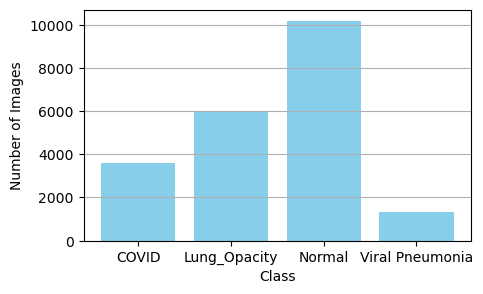

In [3]:
class_counts = {}
for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

plt.figure(figsize=(5, 3))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
#plt.title('Class Distribution in COVID-19 Radiography Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y')
plt.show()

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(image_size, image_size),
    color_mode='grayscale',
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical' 
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(image_size, image_size),
    color_mode='grayscale',
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical' 
)

class_names_train = train_ds.class_names
class_names_val = val_ds.class_names
covid_class_idx = class_names_train.index('COVID')
print(class_names_train)
print(class_names_val)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [5]:
# CNN model
model = models.Sequential()

model.add(layers.Rescaling(1./255, input_shape=(image_size, image_size, 1)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

In [6]:
# Learning rate adjustment
initial_lr = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=1000,
    decay_rate=0.97,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

covid_recall = tf.keras.metrics.Recall(
                  class_id=covid_class_idx,
                  name='covid_recall')

class_weight = {
    0: 3.0,  # COVID
    1: 1.0,  # Lung Opacity
    2: 1.0,  # Normal
    3: 1.0   # Viral Pneumonia
}

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', covid_recall])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    class_weight = class_weight,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_covid_recall', patience=3, mode='max')
                    ])

Epoch 1/30
530/530 [==============================] - 59s 110ms/step - loss: 1.4182 - accuracy: 0.4803 - covid_recall: 0.3069 - val_loss: 0.8412 - val_accuracy: 0.6759 - val_covid_recall: 0.0912
Epoch 2/30
530/530 [==============================] - 45s 84ms/step - loss: 1.0741 - accuracy: 0.6402 - covid_recall: 0.6366 - val_loss: 0.7301 - val_accuracy: 0.6981 - val_covid_recall: 0.7013
Epoch 3/30
530/530 [==============================] - 48s 91ms/step - loss: 0.9518 - accuracy: 0.6942 - covid_recall: 0.7420 - val_loss: 0.6776 - val_accuracy: 0.7425 - val_covid_recall: 0.7630
Epoch 4/30
530/530 [==============================] - 45s 85ms/step - loss: 0.8856 - accuracy: 0.7276 - covid_recall: 0.7737 - val_loss: 0.6199 - val_accuracy: 0.7746 - val_covid_recall: 0.6928
Epoch 5/30
530/530 [==============================] - 49s 92ms/step - loss: 0.8345 - accuracy: 0.7436 - covid_recall: 0.7947 - val_loss: 0.5783 - val_accuracy: 0.7942 - val_covid_recall: 0.6928
Epoch 6/30
530/530 [=========

1/1 [==============================] - 0s 55ms/step


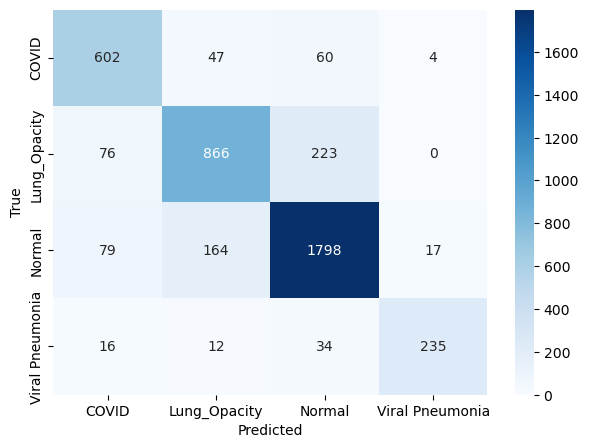

In [12]:
# Labeling the confusion matrix
class_names = val_ds.class_names  # e.g., ['COVID', 'Normal', 'Bacterial', 'Viral']
num_classes = len(class_names)

y_true = []
y_pred = []
y_probs = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to integer
    y_pred.extend(np.argmax(preds, axis=1))           # Predicted class
    y_probs.extend(preds)                             # Softmax probabilities

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.title('Confusion Matrix')
plt.show()



In [8]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Precision and Recall
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")

# Full classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Accuracy: 0.8271
Root Mean Squared Error (RMSE): 0.5637
Macro Precision: 0.8355
Macro Recall: 0.8131

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.78      0.84      0.81       713
   Lung_Opacity       0.80      0.74      0.77      1165
         Normal       0.85      0.87      0.86      2058
Viral Pneumonia       0.92      0.79      0.85       297

       accuracy                           0.83      4233
      macro avg       0.84      0.81      0.82      4233
   weighted avg       0.83      0.83      0.83      4233



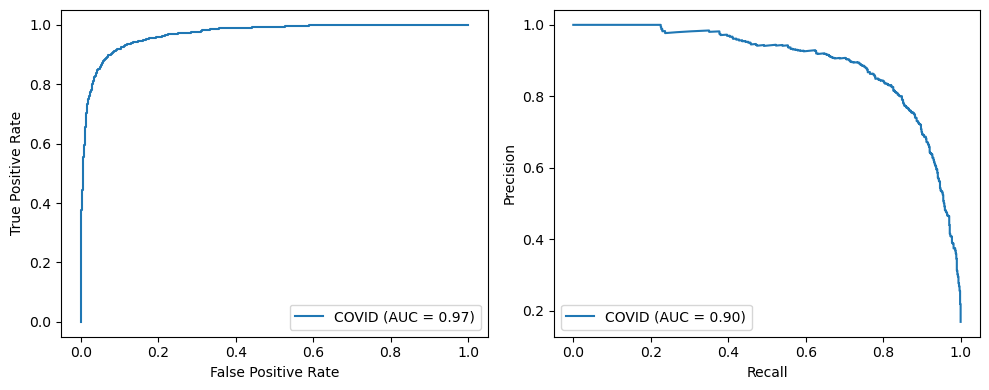

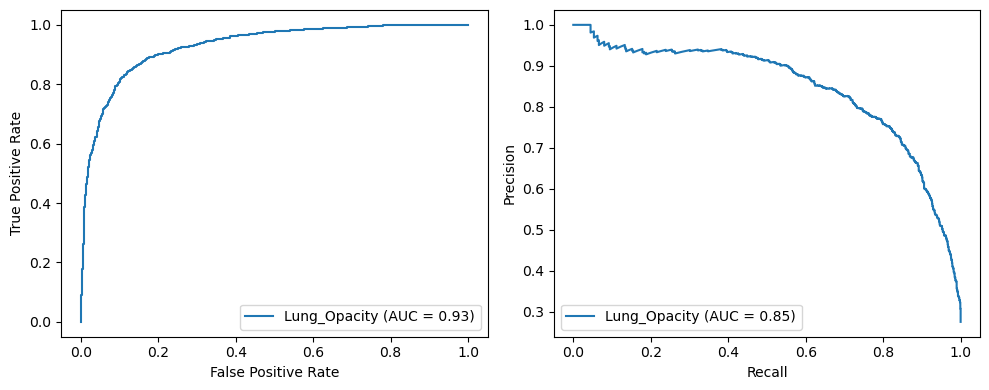

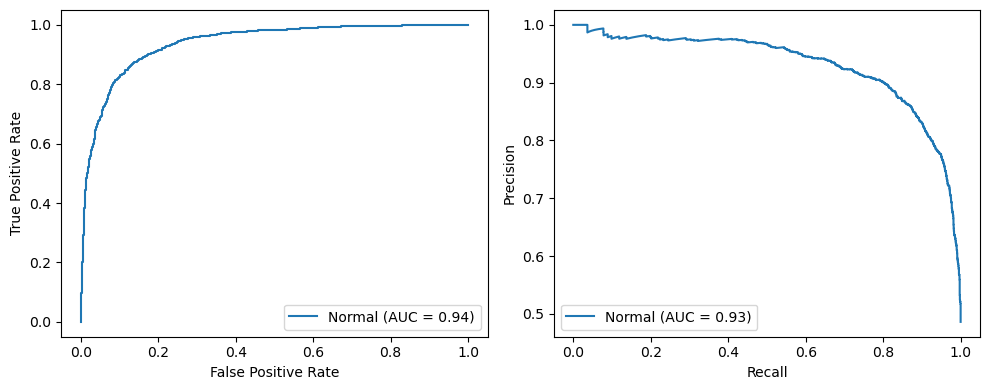

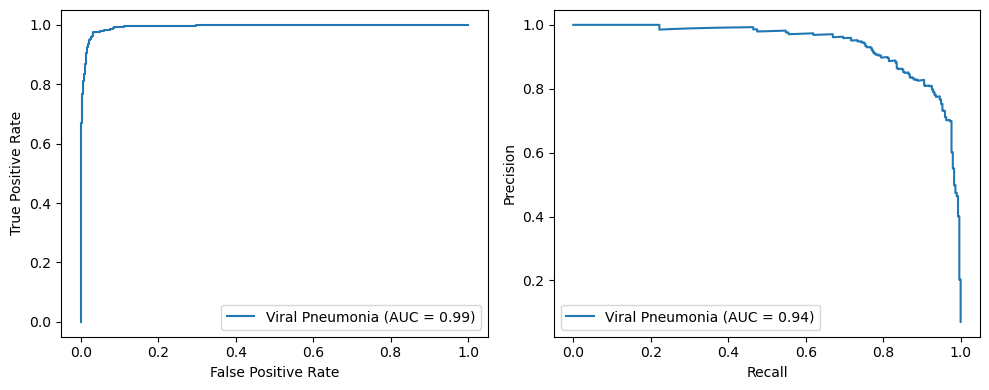

In [9]:
# Precision-Recall and ROC Curves for Each Class
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])

    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall_curve, precision_curve)

    plt.figure(figsize=(10, 4))

    # ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # PR curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_curve, precision_curve, label=f'{class_names[i]} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    #plt.suptitle(f"Class: {class_names[i]}")
    plt.tight_layout()
    plt.show()